In [ ]:
import urllib.request
import bz2
import os

url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
compressed_path = "shape_predictor_68_face_landmarks.dat.bz2"
extracted_path = "shape_predictor_68_face_landmarks.dat"

if not os.path.exists(extracted_path):
    print("Downloading landmark model...")
    urllib.request.urlretrieve(url, compressed_path)

    print("Extracting...")
    with bz2.BZ2File(compressed_path) as fr, open(extracted_path, "wb") as fw:
        fw.write(fr.read())

    print("Done.")
else:
    print("Landmark model already exists.")


Extracting...
Done.


In [ ]:
import cv2
import dlib
import numpy as np
import time

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def extract_dlib_sequence(
    video_path,
    smooth_win=5,
    max_frames=None
):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fps = fps if fps > 0 else 30.0

    ratios = []
    seq = []
    latencies = []
    detected = 0
    total = 0

    while True:
        if max_frames and total >= max_frames:
            break

        ret, frame = cap.read()
        if not ret:
            break

        t0 = time.perf_counter()
        total += 1

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = detector(gray, 0)

        if faces:
            detected += 1
            shape = predictor(gray, faces[0])

            # Key points
            upper_lip = np.array([shape.part(62).x, shape.part(62).y])
            lower_lip = np.array([shape.part(66).x, shape.part(66).y])
            nose_top  = np.array([shape.part(27).x, shape.part(27).y])
            chin      = np.array([shape.part(8).x,  shape.part(8).y])

            lip_open = np.linalg.norm(upper_lip - lower_lip)
            face_h   = np.linalg.norm(nose_top - chin)

            if face_h > 1e-6:
                ratio = lip_open / face_h
                ratios.append(ratio)
                seq.append([ratio])

        t1 = time.perf_counter()
        latencies.append((t1 - t0) * 1000)

    cap.release()


    if len(ratios) >= smooth_win:
        kernel = np.ones(smooth_win) / smooth_win
        ratios = np.convolve(ratios, kernel, mode="same")
        for i in range(len(seq)):
            seq[i][0] = ratios[i]

    duration = total / fps

    stats = {
        "fps": fps,
        "duration_sec": duration,
        "detection_rate": detected / total if total else 0,
        "avg_latency_ms": np.mean(latencies) if latencies else 0
    }

    return seq, ratios, stats


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567858 sha256=4ebbb7b4cc64d373b0f857a23cfea78734f5a900c8af3a37c5f02f92e5e22682
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [ ]:
from fastdtw import fastdtw

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def extract_per_frame(video_path, max_frames=None):
    if not os.path.exists(video_path):
        raise RuntimeError(f"Video file does not exist at path: {video_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Could not open video via OpenCV: {video_path}")

    r_old, r_full, p_raw, p_valid = [], [], [], []
    total_frames = 0
    detected = 0

    while True:
        if max_frames is not None and total_frames >= max_frames:
            break

        ret, frame = cap.read()
        if not ret:
            break

        total_frames += 1
        ratio_old, ratio_full, n_pts, n_v, _ = get_ratios_and_points_dlib(frame)

        p_raw.append(n_pts)
        p_valid.append(n_v)

        if ratio_old is None and ratio_full is None:
            r_old.append(np.nan)
            r_full.append(np.nan)
        else:
            r_old.append(np.nan if ratio_old is None else float(ratio_old))
            r_full.append(np.nan if ratio_full is None else float(ratio_full))
            detected += 1

    cap.release()

    detection_rate = detected / total_frames if total_frames > 0 else 0.0
    print(f"{video_path}: frames={total_frames}, detected={detected}, detection_rate={detection_rate:.1%}")

    return (
        np.array(r_old, dtype=np.float32),
        np.array(r_full, dtype=np.float32),
        np.array(p_raw, dtype=np.int32),
        np.array(p_valid, dtype=np.int32),
    )




def fastdtw_similarity(a, b):
    if fastdtw is None:
        return None, None, None

    mask = np.isfinite(a) & np.isfinite(b)
    aa = a[mask].astype(float)
    bb = b[mask].astype(float)
    if len(aa) < 2 or len(bb) < 2:
        return None, None, None

    dist, path = fastdtw(aa, bb)
    path_len = len(path) if path is not None else max(len(aa), len(bb))
    dtw_cost = float(dist) / (float(path_len) + 1e-9)
    return float(dist), int(path_len), dtw_cost

### AI Score calculation across five video sets of stepwise mouth-closing (Δ = 20° per step) and compared with human scores

/content/drive/MyDrive/speechTherapy/set0/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set0/incorrect.mp4: frames=117, detected=117, detection_rate=100.0%
set0: dtw_cost=0.0
/content/drive/MyDrive/speechTherapy/set1/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set1/incorrect.mp4: frames=118, detected=118, detection_rate=100.0%
set1: dtw_cost=0.03636848032444211
/content/drive/MyDrive/speechTherapy/set2/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set2/incorrect.mp4: frames=128, detected=128, detection_rate=100.0%
set2: dtw_cost=0.04562562570318938
/content/drive/MyDrive/speechTherapy/set3/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set3/incorrect.mp4: frames=127, detected=127, detection_rate=100.0%
set3: dtw_cost=0.0823907412772595
/content/drive/MyDrive/speechTherapy/set4/cor

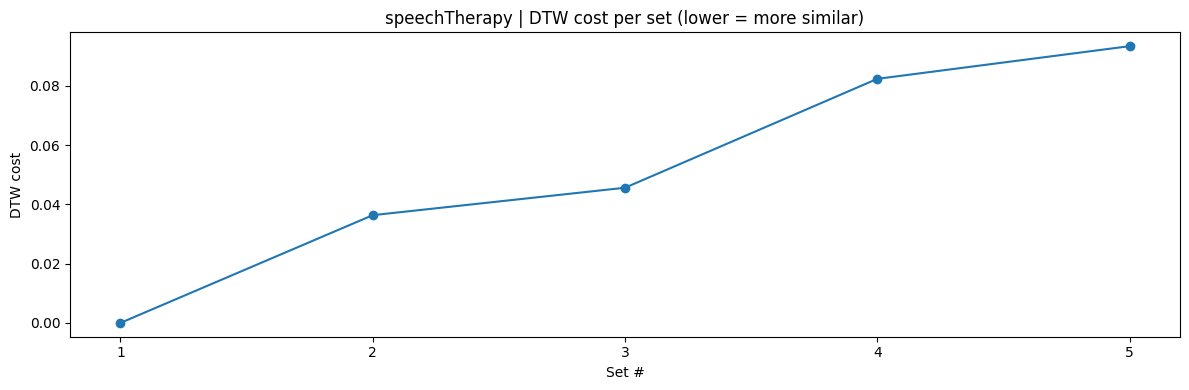

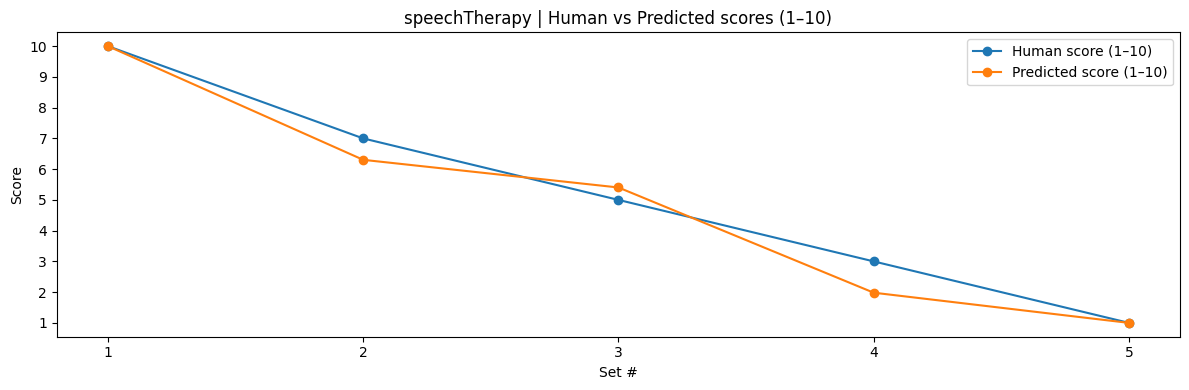

In [ ]:
import os
import numpy as np


def distance_correlation(x, y):
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    n = x.shape[0]

    def pdist(a):

        return np.abs(a - a.T)

    A = pdist(x)
    B = pdist(y)


    A_mean_row = A.mean(axis=1, keepdims=True)
    A_mean_col = A.mean(axis=0, keepdims=True)
    A_mean_all = A.mean()
    A_cent = A - A_mean_row - A_mean_col + A_mean_all

    B_mean_row = B.mean(axis=1, keepdims=True)
    B_mean_col = B.mean(axis=0, keepdims=True)
    B_mean_all = B.mean()
    B_cent = B - B_mean_row - B_mean_col + B_mean_all

    dcov2 = (A_cent * B_cent).mean()
    dvarx = (A_cent * A_cent).mean()
    dvary = (B_cent * B_cent).mean()

    if dvarx <= 1e-12 or dvary <= 1e-12:
        return 0.0
    return float(np.sqrt(dcov2 / np.sqrt(dvarx * dvary)))

def plot_results(dtw_costs, human_scores, pred_scores_1to10, title_prefix=""):
    import numpy as np
    import matplotlib.pyplot as plt

    dtw_costs = np.asarray(dtw_costs, dtype=float)
    human_scores = np.asarray(human_scores, dtype=float)
    pred_scores_1to10 = np.asarray(pred_scores_1to10, dtype=float)

    sets = np.arange(1, len(human_scores) + 1)


    plt.figure(figsize=(12, 4))
    plt.plot(sets, dtw_costs, marker="o")
    plt.title(f"{title_prefix}DTW cost per set (lower = more similar)")
    plt.xlabel("Set #")
    plt.ylabel("DTW cost")
    plt.xticks(sets)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 4))
    plt.plot(sets, human_scores, marker="o", label="Human score (1–10)")
    plt.plot(sets, pred_scores_1to10, marker="o", label="Predicted score (1–10)")
    plt.title(f"{title_prefix}Human vs Predicted scores (1–10)")
    plt.xlabel("Set #")
    plt.ylabel("Score")
    plt.xticks(sets)
    plt.yticks(range(1, 11))
    plt.legend()
    plt.tight_layout()
    plt.show()



def concordance_ccc(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    cov = np.cov(x, y, ddof=1)[0, 1]
    denom = vx + vy + (mx - my) ** 2
    if denom <= 1e-12:
        return 0.0
    return float((2 * cov) / denom)


def to_1_to_10_scale(pred_sim):
    pred_sim = np.asarray(pred_sim, dtype=float)
    mn, mx = np.min(pred_sim), np.max(pred_sim)
    if abs(mx - mn) < 1e-12:
        return np.full_like(pred_sim, 5.5)
    scaled = 1 + 9 * (pred_sim - mn) / (mx - mn)
    return scaled


def dtw_cost_for_pair(video1_path, video2_path, use_ratio="full", max_frames=None):

    r1_old, r1_full, p1, pv1 = extract_per_frame(video1_path, max_frames=max_frames)
    r2_old, r2_full, p2, pv2 = extract_per_frame(video2_path, max_frames=max_frames)

    n = min(len(r1_old), len(r2_old))
    r1_old, r1_full = r1_old[:n], r1_full[:n]
    r2_old, r2_full = r2_old[:n], r2_full[:n]

    r1 = r1_full if use_ratio == "full" else r1_old
    r2 = r2_full if use_ratio == "full" else r2_old


    _, _, cost = fastdtw_similarity(r1, r2)
    return cost


def run_all_sets(base_dir, human_scores, use_ratio="full", max_frames=None):
    """
    base_dir/
      set1/correct.mp4, incorrect.mp4
      ...
      set5/correct.mp4, incorrect.mp4
    """
    dtw_costs = []
    for i in range(0, 5):
        folder = os.path.join(base_dir, f"set{i}")
        v1 = os.path.join(folder, "correct.mp4")
        v2 = os.path.join(folder, "incorrect.mp4")

        if not (os.path.exists(v1) and os.path.exists(v2)):
            raise RuntimeError(f"Missing videos in {folder}. Expected 'correct.mp4' and 'incorrect.mp4'.")

        cost = dtw_cost_for_pair(v1, v2, use_ratio=use_ratio, max_frames=max_frames)
        dtw_costs.append(np.nan if cost is None else float(cost))
        print(f"set{i}: dtw_cost={dtw_costs[-1]}")

    human = np.asarray(human_scores, dtype=float)
    dtw_costs = np.asarray(dtw_costs, dtype=float)


    mask = np.isfinite(dtw_costs) & np.isfinite(human)
    human = human[mask]
    dtw_costs = dtw_costs[mask]

    if len(human) < 2:
        raise RuntimeError("Not enough valid pairs to compute correlation (need at least 2).")


    dtw_sim = 1.0 / (1.0 + dtw_costs)
    pred_1to10 = to_1_to_10_scale(dtw_sim)

    return human, dtw_costs, dtw_sim, pred_1to10


def compute_metrics(human, pred_sim, pred_1to10):
    from scipy.stats import spearmanr, pearsonr, kendalltau

    human = np.asarray(human, dtype=float)
    pred_sim = np.asarray(pred_sim, dtype=float)
    pred_1to10 = np.asarray(pred_1to10, dtype=float)


    spearman = spearmanr(human, pred_sim).correlation
    pearson = pearsonr(human, pred_sim).statistic
    kendall = kendalltau(human, pred_sim).correlation


    dcor = distance_correlation(human, pred_sim)


    ccc = concordance_ccc(human, pred_1to10)


    denom = (np.linalg.norm(human) * np.linalg.norm(pred_1to10) + 1e-12)
    cosine = float(np.dot(human, pred_1to10) / denom)


    mae = float(np.mean(np.abs(human - pred_1to10)))
    rmse = float(np.sqrt(np.mean((human - pred_1to10) ** 2)))

    print("\n=== Metrics (Human vs DTW-derived similarity) ===")
    print(f"Spearman    : {spearman:.3f}")
    print(f"Pearson     : {pearson:.3f}")
    print(f"KendallTau  : {kendall:.3f}")
    print(f"dCor        : {dcor:.3f}")
    print(f"CCC         : {ccc:.3f}")
    print(f"CosineSim   : {cosine:.3f}")
    print(f"MAE         : {mae:.3f}")
    print(f"RMSE        : {rmse:.3f}")

    return {
        "Spearman": spearman,
        "Pearson": pearson,
        "KendallTau": kendall,
        "dCor": dcor,
        "CCC": ccc,
        "CosineSim": cosine,
        "MAE": mae,
        "RMSE": rmse,
    }

# -------------------- RUN HERE --------------------
# 1) Put your folder path here (Drive example in Colab):
# base_dir = "/content/drive/MyDrive/your_folder_name"
base_dir = "/content/drive/MyDrive/speechTherapy"


human_scores = [10, 7, 5, 3, 1]

human, dtw_costs, dtw_sim, pred_1to10 = run_all_sets(
    base_dir=base_dir,
    human_scores=human_scores,
    use_ratio="full",
    max_frames=None
)

metrics = compute_metrics(human, dtw_sim, pred_1to10)

plot_results(dtw_costs, human_scores, pred_1to10, title_prefix="speechTherapy | ")

### Stability and latency evaluation across five video sets of stepwise mouth-closing (Δ = 20° per step)

/content/drive/MyDrive/speechTherapy/set0/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set0/incorrect.mp4: frames=117, detected=117, detection_rate=100.0%

Latency:
  Video1 avg processing time per frame: 132.39 ms
  Video2 avg processing time per frame: 131.79 ms
  Video1 total processing time: 15489.08 ms
  Video2 total processing time: 15419.50 ms
  Pair total processing time: 30908.58 ms

Stability (ratio std-dev on still segment):
  Video1 std over first 30 frames: 0.006138
  Video2 std over first 30 frames: 0.006138

set0: dtw_cost=0.0
/content/drive/MyDrive/speechTherapy/set1/correct.mp4: frames=117, detected=117, detection_rate=100.0%
/content/drive/MyDrive/speechTherapy/set1/incorrect.mp4: frames=118, detected=118, detection_rate=100.0%

Latency:
  Video1 avg processing time per frame: 133.08 ms
  Video2 avg processing time per frame: 133.75 ms
  Video1 total processing time: 15570.34 ms
  Video2 total processing time: 15782

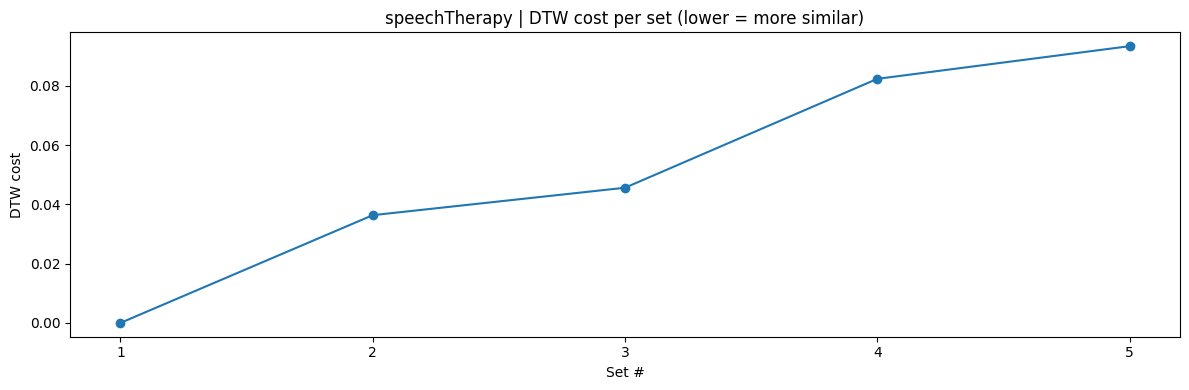

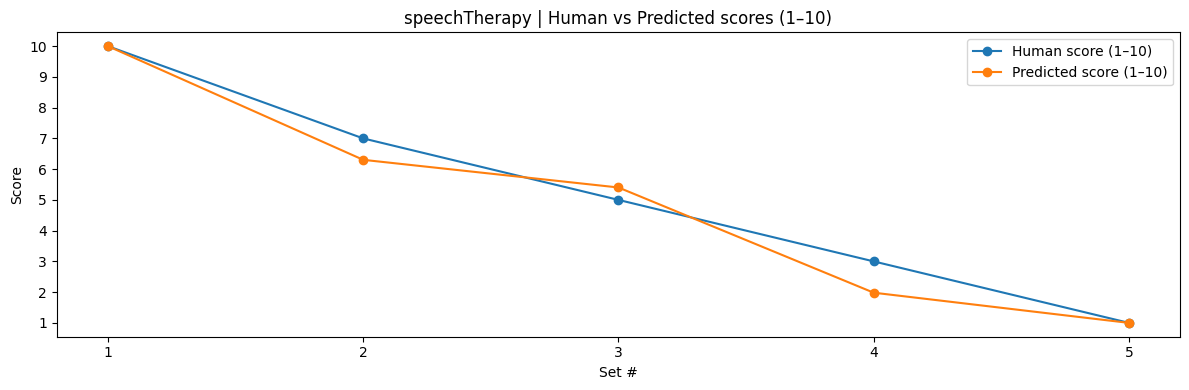

In [ ]:
base_dir = "/content/drive/MyDrive/speechTherapy"
human_scores = [10, 7, 5, 3, 1]

human, dtw_costs, dtw_sim, pred_1to10, debug_list = run_all_sets(
    base_dir=base_dir,
    human_scores=human_scores,
    use_ratio="full",
    set_start=0,
    still_frames=30
)

metrics = compute_metrics(human, dtw_sim, pred_1to10)
plot_results(dtw_costs, human_scores, pred_1to10, title_prefix="speechTherapy | ")


### Comparing 10 video sets with human score and AI scores

/content/drive/MyDrive/SpeechDataset/set0/correct.mp4: frames=81, detected=81, detection_rate=100.0%
/content/drive/MyDrive/SpeechDataset/set0/incorrect.mp4: frames=79, detected=79, detection_rate=100.0%
set0: dtw_cost=0.0042532641377129
/content/drive/MyDrive/SpeechDataset/set1/correct.mp4: frames=96, detected=92, detection_rate=95.8%
/content/drive/MyDrive/SpeechDataset/set1/incorrect.mp4: frames=76, detected=76, detection_rate=100.0%
set1: dtw_cost=0.005232690905104443
/content/drive/MyDrive/SpeechDataset/set2/correct.mp4: frames=96, detected=71, detection_rate=74.0%
/content/drive/MyDrive/SpeechDataset/set2/incorrect.mp4: frames=96, detected=96, detection_rate=100.0%
set2: dtw_cost=0.009373163235716282
/content/drive/MyDrive/SpeechDataset/set3/correct.mp4: frames=101, detected=99, detection_rate=98.0%
/content/drive/MyDrive/SpeechDataset/set3/incorrect.mp4: frames=85, detected=82, detection_rate=96.5%
set3: dtw_cost=0.004848717541756139
/content/drive/MyDrive/SpeechDataset/set4/cor

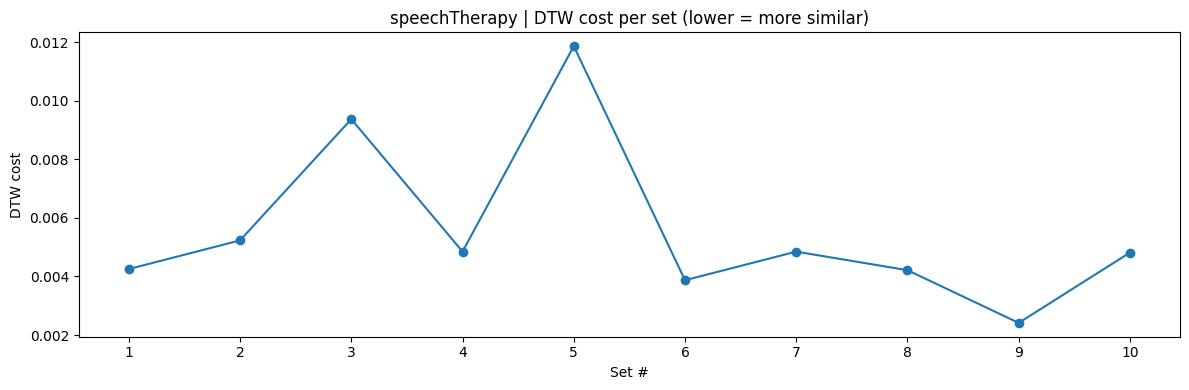

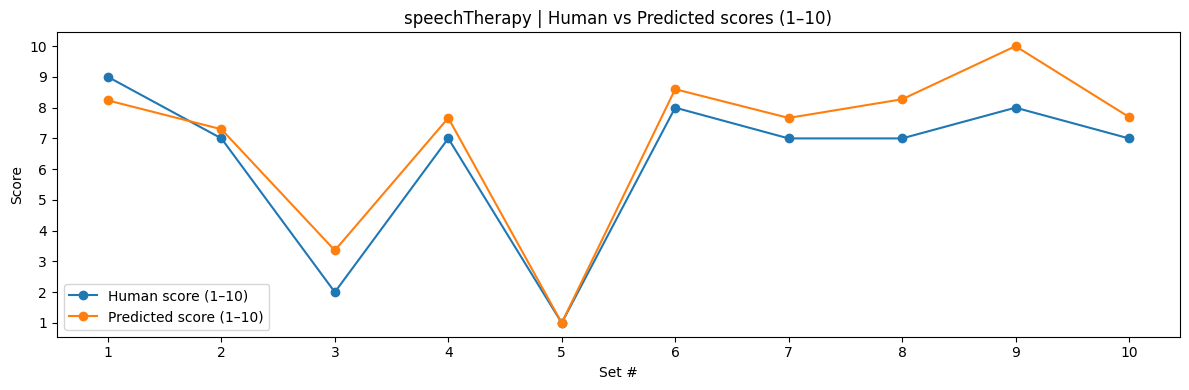

In [ ]:
import os
import numpy as np


def distance_correlation(x, y):
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    n = x.shape[0]

    def pdist(a):

        return np.abs(a - a.T)

    A = pdist(x)
    B = pdist(y)


    A_mean_row = A.mean(axis=1, keepdims=True)
    A_mean_col = A.mean(axis=0, keepdims=True)
    A_mean_all = A.mean()
    A_cent = A - A_mean_row - A_mean_col + A_mean_all

    B_mean_row = B.mean(axis=1, keepdims=True)
    B_mean_col = B.mean(axis=0, keepdims=True)
    B_mean_all = B.mean()
    B_cent = B - B_mean_row - B_mean_col + B_mean_all

    dcov2 = (A_cent * B_cent).mean()
    dvarx = (A_cent * A_cent).mean()
    dvary = (B_cent * B_cent).mean()

    if dvarx <= 1e-12 or dvary <= 1e-12:
        return 0.0
    return float(np.sqrt(dcov2 / np.sqrt(dvarx * dvary)))

def plot_results(dtw_costs, human_scores, pred_scores_1to10, title_prefix=""):
    import numpy as np
    import matplotlib.pyplot as plt

    dtw_costs = np.asarray(dtw_costs, dtype=float)
    human_scores = np.asarray(human_scores, dtype=float)
    pred_scores_1to10 = np.asarray(pred_scores_1to10, dtype=float)

    sets = np.arange(1, len(human_scores) + 1)


    plt.figure(figsize=(12, 4))
    plt.plot(sets, dtw_costs, marker="o")
    plt.title(f"{title_prefix}DTW cost per set (lower = more similar)")
    plt.xlabel("Set #")
    plt.ylabel("DTW cost")
    plt.xticks(sets)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(12, 4))
    plt.plot(sets, human_scores, marker="o", label="Human score (1–10)")
    plt.plot(sets, pred_scores_1to10, marker="o", label="Predicted score (1–10)")
    plt.title(f"{title_prefix}Human vs Predicted scores (1–10)")
    plt.xlabel("Set #")
    plt.ylabel("Score")
    plt.xticks(sets)
    plt.yticks(range(1, 11))
    plt.legend()
    plt.tight_layout()
    plt.show()



def concordance_ccc(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mx, my = x.mean(), y.mean()
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    cov = np.cov(x, y, ddof=1)[0, 1]
    denom = vx + vy + (mx - my) ** 2
    if denom <= 1e-12:
        return 0.0
    return float((2 * cov) / denom)


def to_1_to_10_scale(pred_sim):
    pred_sim = np.asarray(pred_sim, dtype=float)
    mn, mx = np.min(pred_sim), np.max(pred_sim)
    if abs(mx - mn) < 1e-12:
        return np.full_like(pred_sim, 5.5)
    scaled = 1 + 9 * (pred_sim - mn) / (mx - mn)
    return scaled


def dtw_cost_for_pair(video1_path, video2_path, use_ratio="full", max_frames=None):

    r1_old, r1_full, p1, pv1 = extract_per_frame(video1_path, max_frames=max_frames)
    r2_old, r2_full, p2, pv2 = extract_per_frame(video2_path, max_frames=max_frames)

    n = min(len(r1_old), len(r2_old))
    r1_old, r1_full = r1_old[:n], r1_full[:n]
    r2_old, r2_full = r2_old[:n], r2_full[:n]

    r1 = r1_full if use_ratio == "full" else r1_old
    r2 = r2_full if use_ratio == "full" else r2_old


    _, _, cost = fastdtw_similarity(r1, r2)
    return cost

# ---------- Folder runner (set1..set5) ----------
def run_all_sets(base_dir, human_scores, use_ratio="full", max_frames=None):
    """
    base_dir/
      set1/correct.mp4, incorrect.mp4
      ...
      set5/correct.mp4, incorrect.mp4
    """
    dtw_costs = []
    for i in range(0, 10):
        folder = os.path.join(base_dir, f"set{i}")
        v1 = os.path.join(folder, "correct.mp4")
        v2 = os.path.join(folder, "incorrect.mp4")

        if not (os.path.exists(v1) and os.path.exists(v2)):
            raise RuntimeError(f"Missing videos in {folder}. Expected 'correct.mp4' and 'incorrect.mp4'.")

        cost = dtw_cost_for_pair(v1, v2, use_ratio=use_ratio, max_frames=max_frames)
        dtw_costs.append(np.nan if cost is None else float(cost))
        print(f"set{i}: dtw_cost={dtw_costs[-1]}")

    human = np.asarray(human_scores, dtype=float)
    dtw_costs = np.asarray(dtw_costs, dtype=float)


    mask = np.isfinite(dtw_costs) & np.isfinite(human)
    human = human[mask]
    dtw_costs = dtw_costs[mask]

    if len(human) < 2:
        raise RuntimeError("Not enough valid pairs to compute correlation (need at least 2).")

    dtw_sim = 1.0 / (1.0 + dtw_costs)


    pred_1to10 = to_1_to_10_scale(dtw_sim)

    return human, dtw_costs, dtw_sim, pred_1to10


def compute_metrics(human, pred_sim, pred_1to10):
    from scipy.stats import spearmanr, pearsonr, kendalltau

    human = np.asarray(human, dtype=float)
    pred_sim = np.asarray(pred_sim, dtype=float)
    pred_1to10 = np.asarray(pred_1to10, dtype=float)


    spearman = spearmanr(human, pred_sim).correlation
    pearson = pearsonr(human, pred_sim).statistic
    kendall = kendalltau(human, pred_sim).correlation


    dcor = distance_correlation(human, pred_sim)


    ccc = concordance_ccc(human, pred_1to10)


    denom = (np.linalg.norm(human) * np.linalg.norm(pred_1to10) + 1e-12)
    cosine = float(np.dot(human, pred_1to10) / denom)


    mae = float(np.mean(np.abs(human - pred_1to10)))
    rmse = float(np.sqrt(np.mean((human - pred_1to10) ** 2)))

    print("\n=== Metrics (Human vs DTW-derived similarity) ===")
    print(f"Spearman    : {spearman:.3f}")
    print(f"Pearson     : {pearson:.3f}")
    print(f"KendallTau  : {kendall:.3f}")
    print(f"dCor        : {dcor:.3f}")
    print(f"CCC         : {ccc:.3f}")
    print(f"CosineSim   : {cosine:.3f}")
    print(f"MAE         : {mae:.3f}")
    print(f"RMSE        : {rmse:.3f}")

    return {
        "Spearman": spearman,
        "Pearson": pearson,
        "KendallTau": kendall,
        "dCor": dcor,
        "CCC": ccc,
        "CosineSim": cosine,
        "MAE": mae,
        "RMSE": rmse,
    }


base_dir = "/content/drive/MyDrive/SpeechDataset"


human_scores = [9,7,2,7,1,8,7,7,8,7]

human, dtw_costs, dtw_sim, pred_1to10 = run_all_sets(
    base_dir=base_dir,
    human_scores=human_scores,
    use_ratio="full",
    max_frames=None
)

metrics = compute_metrics(human, dtw_sim, pred_1to10)

plot_results(dtw_costs, human_scores, pred_1to10, title_prefix="speechTherapy | ")